In [5]:
import jax
from jax import numpy as jnp
from jax.numpy import linalg as jla
import jax.nn as nn
from jax.config import config; config.update("jax_enable_x64", True)

import matplotlib.pyplot as plt
from matplotlib import patches

import sys
sys.path.insert(1, '..')


from env.gridworld import Gridworld,gridplot
from env.complete import Complete
from algs.opt import Optimizer
from algs.pg import *
from algs.irl import *
from algs.returns import J, IRLLagrangian
from algs.utils import shannonEntropy
from algs.projs import euclidean_l2ball

from env.sample import Sampler

In [6]:
def getExpertPolicy(mdp,key,beta):
    LR = 5e-3
    CLIP_THRESH = 5e2
    STEPS = 40
    pFun = lambda p : nn.softmax(p,axis=1)  # policy function
    rFun = lambda r : r                     # reward function
    reg = lambda p : - beta * shannonEntropy(p)
    
    init = initDirectPG(key,mdp)                    # init function
    grad = exactNaturalPG(J,mdp,pFun,rFun,reg)      # gradient function
    proc = pgClipProcessor(LR,CLIP_THRESH)
    
    opt = Optimizer(init=init,grad=grad,proc=proc,log=lambda x,_g,_s,i : None,proj=lambda x: x)
    p, _ = opt.train(key,STEPS,True)
    return pFun(p['policy'])

In [7]:
pFun = lambda p : nn.softmax(p,axis=1)  # policy function
W_RADIUS = 1
def train_irl(PLR,RLR,STEPS):
    key = jax.random.PRNGKey(0) 
        
    # PLR = 2e-3
    # RLR = 1
    CLIP_THRESH = 7e2
    # STEPS = 40

    BETA = 1

    """Defining an MDP"""
    R = 100; P = -300; 
    # goals = [((2,0),R),((1,0),P),((1,1),P)]
    goals = [((2,0),R)]
    mdp = Complete(2,2,0.95)
    # mdp = Gridworld(3,3,0.1,0.9,goals=goals,obstacles=[]) 
    key, sk = jax.random.split(key)
    mdp.init_distrib = jnp.exp(jax.random.uniform(sk,(mdp.n,))) / \
    jnp.sum(jnp.exp(jax.random.uniform(key,(mdp.n,))))
    mdp.R = euclidean_l2ball(mdp.R, W_RADIUS)

    """Recovering the expert policy (that we are going recover to clone)"""
    print("Computing the expert's policy")
    expertPolicy = getExpertPolicy(mdp,key,BETA)
    L = IRLLagrangian(expertPolicy)

    """Defining the relevant function"""
    rFun = lambda r : r                     # reward function (for now we just parametrize directly)
    reg = lambda p : - BETA * shannonEntropy(p)

    init = initDirectIRL(key,mdp)                   # init function
    grad = exactNaturalIRL(L,mdp,pFun,rFun,reg)      # gradient function 
    proc = irlClipProcessor(PLR,RLR,CLIP_THRESH)        # gradient processing
    proj = irlL2Proj(W_RADIUS)


    def policyReconstructionError(policy):
        # TODO: create a metrics module
        diff = policy-expertPolicy
        return jnp.sum(jla.norm(diff,ord=1,axis=1))

    def normalizedRewardError(reward):
        normalize = lambda x : x/jla.norm(x)
        # TODO: create a metrics module
        diff = normalize(reward)-normalize(mdp.R)
        return jnp.sum(jla.norm(diff,ord=1,axis=1))

    """Defining the logger"""
    def logger( params, grads, step, i):
        return {
            'L'         : L(mdp,pFun(params['policy']),rFun(params['reward']),reg), 
            'PRE'       : policyReconstructionError(pFun(params['policy'])),
            'NRE'       : normalizedRewardError(rFun(params['reward'])),
            'params'    : params,
            'grads'     : grads,
            'step'      : step,
            'iter'      : i
        }
            
    """Optimizing"""
    opt = Optimizer(init=init,grad=grad,proc=proc,log=logger,proj=proj)
    o, log = opt.train(key,STEPS,True)
    return o, log, expertPolicy, mdp.R

Computing the expert's policy


100%|██████████| 500/500 [00:10<00:00, 48.33it/s]


[[0.46267919 0.53732081]
 [0.47755603 0.52244397]] [[0.46459944 0.53540056]
 [0.47727151 0.52272849]]
[[0.38238834 0.56059652]
 [0.30991847 0.42093042]] [[0.37951281 0.51538461]
 [0.40096454 0.6554206 ]]


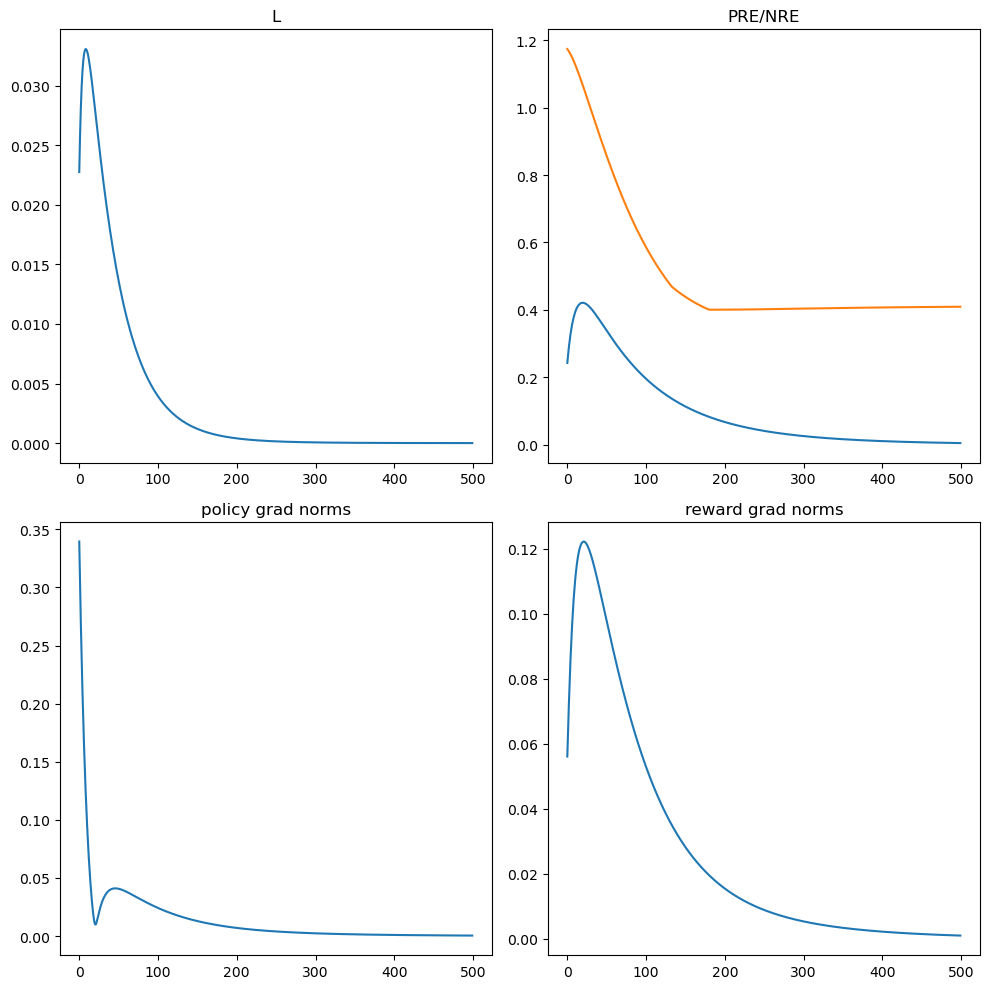

In [8]:
o, log, expertP,expertR = train_irl(1e-1,4e-2,500)
print(pFun(o['policy']),expertP)
print((o['reward']),expertR)
ls = [e['L'] for e in log]
pre = [e['PRE'] for e in log]
nre = [e['NRE'] for e in log]
pgnorms = [jla.norm(e['grads']['policy']) for e in log]
rgnorms = [jla.norm(e['grads']['reward']) for e in log]
fig, ax = plt.subplots(2,2,figsize=(10,10))
ax[0,0].plot(ls)
ax[0,0].set_title('L')
ax[0,1].plot(pre)
ax[0,1].plot(nre)
ax[0,1].set_title('PRE/NRE')
ax[1,0].plot(pgnorms)
ax[1,0].set_title('policy grad norms')
ax[1,1].plot(rgnorms)
ax[1,1].set_title('reward grad norms')
fig.tight_layout()
plt.show()

In [184]:
jnp.array([(pFun(e['params']['policy'])) for e in log]).shape

(3000, 2, 2)

Text(0.5, 1.0, 'reward parameters')

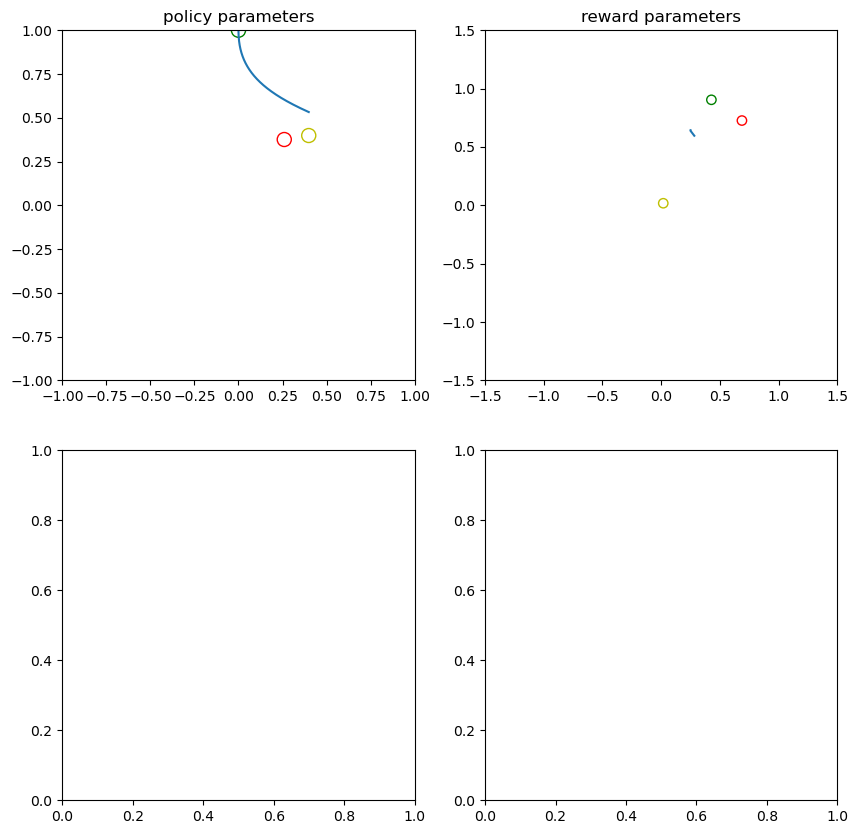

In [186]:
policies = jnp.array([(pFun(e['params']['policy'])) for e in log])[:,:,0]
rewards = jnp.array([normalize(e['params']['reward']) for e in log])[:,:,0]

circle = lambda ax, p, r, c : ax.add_patch(patches.Circle(p,r,fill=False,color=c))
Ncircle = lambda ax, p, r, c : ax.add_patch(patches.Circle(normalize(p),r,fill=False,color=c))

fig, ax = plt.subplots(2,2,figsize=(10,10))
ax[0,0].set_xlim([-1,1]);ax[0,0].set_ylim([-1,1])
circle(ax[0,0],expertP[:,0],.04,'r'), circle(ax[0,0],pFun(o['policy'])[:,0],.04,'g');  circle(ax[0,0],policies[:,0],.04,'y');
ax[0,0].plot(policies[:,0],policies[:,1]); ax[0,0].set_title('policy parameters')

ax[0,1].set_xlim([-W_RADIUS*1.5,W_RADIUS*1.5]);ax[0,1].set_ylim([-W_RADIUS*1.5,W_RADIUS*1.5])
Ncircle(ax[0,1],expertR[:,0],.04,'r'); Ncircle(ax[0,1],o['reward'][:,0],.04,'g'); Ncircle(ax[0,1],rewards[:,0],.04,'y');
ax[0,1].plot(rewards[:,0],rewards[:,1]); ax[0,1].set_title('reward parameters')




In [200]:
pFun(o['policy'])

DeviceArray([[0., 1.],
             [1., 0.]], dtype=float64)

In [209]:
import scipy as sp
p = pFun(o['policy'])
p, jax.grad(lambda p : jnp.sum(jax.scipy.special.entr(p)))(p)

(DeviceArray([[0., 1.],
              [1., 0.]], dtype=float64),
 DeviceArray([[ 0., -1.],
              [-1.,  0.]], dtype=float64))

In [253]:
pFun = lambda p : nn.softmax(p,axis=1)  # policy function
W_RADIUS = 1
def train_rl(PLR,STEPS):
    key = jax.random.PRNGKey(0) 
        
    # PLR = 2e-3
    # RLR = 1
    CLIP_THRESH = 7e2
    # STEPS = 40

    BETA = .3

    """Defining an MDP"""
    R = 100; P = -300; 
    # goals = [((2,0),R),((1,0),P),((1,1),P)]
    goals = [((2,0),R)]
    mdp = Complete(1,2,0.95)
    # mdp = Gridworld(3,3,0.1,0.9,goals=goals,obstacles=[]) 
    key, sk = jax.random.split(key)
    mdp.init_distrib = jnp.exp(jax.random.uniform(sk,(mdp.n,))) / \
    jnp.sum(jnp.exp(jax.random.uniform(key,(mdp.n,))))
    mdp.R = euclidean_l2ball(mdp.R, W_RADIUS)

    """Recovering the expert policy (that we are going recover to clone)"""
    print("Computing the expert's policy")

    """Defining the relevant function"""
    rFun = lambda r : r                     # reward function (for now we just parametrize directly)
    reg = lambda p : -BETA * jnp.sum(jax.scipy.special.entr(p))

    init = initDirectPG(key,mdp)                   # init function
    grad = exactNaturalPG(J,mdp,pFun,rFun,reg)      # gradient function 
    proc = pgClipProcessor(PLR,CLIP_THRESH)        # gradient processing
    proj = lambda x : x



    """Defining the logger"""
    def logger( params, grads, step, i):
        return {
            'J'         : J(mdp,pFun(params['policy']),rFun(params['reward']),reg), 
            'params'    : params,
            'grads'     : grads,
            'step'      : step, 
            'iter'      : i
        }
            
    """Optimizing"""
    opt = Optimizer(init=init,grad=grad,proc=proc,log=logger,proj=proj)
    o, log = opt.train(key,STEPS,True)
    return o, log

Computing the expert's policy


100%|██████████| 40/40 [00:00<00:00, 74.35it/s]


[[0.03463618 0.96536382]] [[0.00205038 0.99794962]
 [0.06839599 0.93160401]]


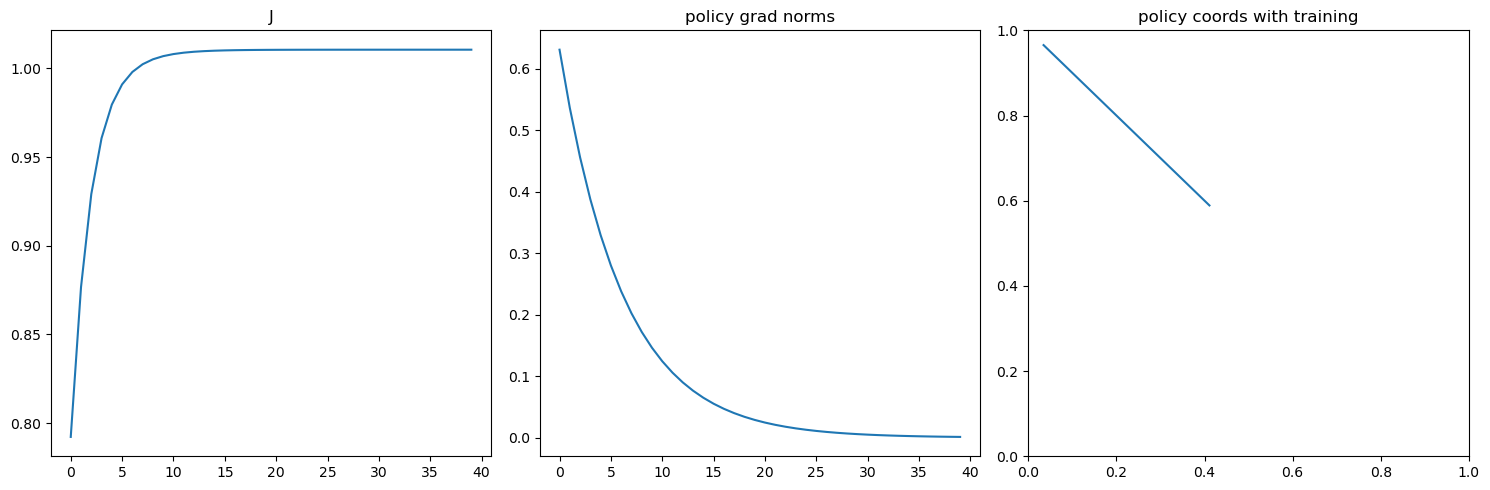

In [254]:
o, log = train_rl(5e-1,40)

print(pFun(o['policy']),expertP)
js = [e['J'] for e in log]
pgnorms = [jla.norm(e['grads']['policy']) for e in log]
rgnorms = [jla.norm(e['grads']['reward']) for e in log]
pols = jnp.array([pFun(e['params']['policy']) for e in log])[:,0,:]
fig, ax = plt.subplots(1,3,figsize=(15,5))
ax[0].plot(js)
ax[0].set_title('J')
ax[1].plot(pgnorms)
ax[1].set_title('policy grad norms')
ax[2].set_xlim([0,1]); ax[2].set_ylim([0,1])
ax[2].plot(pols[:,0],pols[:,1])
ax[2].set_title('policy coords with training')
fig.tight_layout()
plt.show()

[0. 1.]


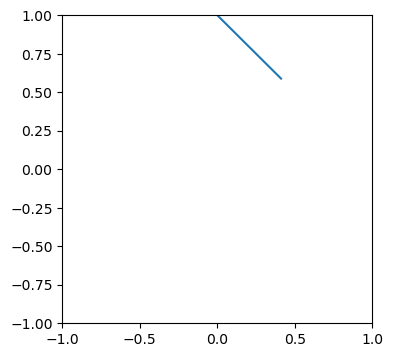

In [172]:
pis = jnp.array([pFun(e['params']['policy']) for e in log])[:,0,:]
fig, ax = plt.subplots(1,figsize=(4,4))
ax.set_xlim([-1,1]);ax.set_ylim([-1,1])
ax.plot(pis[:,0],pis[:,1])
print(pis[-1,:])

In [71]:
import jax
from jax import numpy as jnp
from jax.numpy import linalg as jla
import jax.nn as nn
from jax.config import config; config.update("jax_enable_x64", True)

import matplotlib.pyplot as plt

from env.gridworld import Gridworld,gridplot
from algs.opt import Optimizer
from algs.pg import *
from algs.irl import *
from algs.returns import J, IRLLagrangian
from algs.utils import shannonEntropy

from env.sample import Sampler
    
def getExpertPolicy(mdp,key,beta):
    LR = 5e-3
    CLIP_THRESH = 5e2
    STEPS = 40
    pFun = lambda p : nn.softmax(p,axis=1)  # policy function
    rFun = lambda r : r                     # reward function
    reg = lambda p : - beta * shannonEntropy(p)
    
    init = initDirectPG(key,mdp)                    # init function
    grad = exactNaturalPG(J,mdp,pFun,rFun,reg)      # gradient function
    proc = pgClipProcessor(LR,CLIP_THRESH)
    
    opt = Optimizer(init=init,grad=grad,proc=proc,log=lambda x,_g,_s,i : None,proj=lambda x: x)
    p, _ = opt.train(key,STEPS,True)
    return pFun(p['policy'])
    
def main_irl():
    key = jax.random.PRNGKey(0) 
    
    PLR = 1e-1
    RLR = 1e-2
    CLIP_THRESH = 5e6
    STEPS = 800
    W_RADIUS = 1
    BETA = 10
    
    """Defining an MDP"""
    R = 100; P = -300; 
    # goals = [((2,0),R),((1,0),P),((1,1),P)]
    goals = [((2,0),R)]
    gridMDP = Gridworld(3,3,0.1,0.9,goals=goals,obstacles=[]) 
    gridMDP.init_distrib = jnp.exp(jax.random.uniform(key,(gridMDP.n,))) / \
        jnp.sum(jnp.exp(jax.random.uniform(key,(gridMDP.n,))))
        
    """Recovering the expert policy (that we are going recover to clone)"""
    print("Computing the expert's policy")
    expertPolicy = getExpertPolicy(gridMDP,key,BETA)
    L = IRLLagrangian(expertPolicy)
    
    """Defining the relevant function"""
    pFun = lambda p : nn.softmax(p,axis=1)  # policy function
    rFun = lambda r : r                     # reward function (for now we just parametrize directly)
    reg = lambda p : -BETA * shannonEntropy(p)

    init = initDirectIRL(key,gridMDP)                   # init function
    grad = exactNaturalIRL(L,gridMDP,pFun,rFun,reg)     # gradient function 
    proc = irlClipProcessor(PLR,RLR,CLIP_THRESH)        # gradient processing
    proj = irlL2Proj(W_RADIUS)


    def policyReconstructionError(policy):
        # TODO: create a metrics module
        diff = policy-expertPolicy
        return jnp.sum(jla.norm(diff,ord=1,axis=1))

    """Defining the logger"""
    def logger( params, grads, step, i):
        return {
            'L'         : L(gridMDP,pFun(params['policy']),rFun(params['reward']),reg), 
            'PRE'       : policyReconstructionError(pFun(params['policy'])),
            'params'    : params,
            'grads'     : grads,
            'step'      : step,
            'iter'      : i
        }
            
    """Optimizing"""
    opt = Optimizer(init=init,grad=grad,proc=proc,log=logger,proj=proj)
    o, log = opt.train(key,STEPS,True)

    # ls = [e['L'] for e in log]
    # pre = [e['PRE'] for e in log]
    # fig, ax = plt.subplots(1,2,figsize=(10,5))
    # ax[0].plot(ls)
    # ax[0].set_title('L')
    # ax[1].plot(pre)
    # ax[1].set_title('PRE')
    # fig.tight_layout()
    # plt.show()
    
    
    
    return log, gridMDP, o, expertPolicy
    

log, mdp, o, expert = main_irl()

Computing the expert's policy


100%|██████████| 800/800 [00:15<00:00, 50.77it/s]


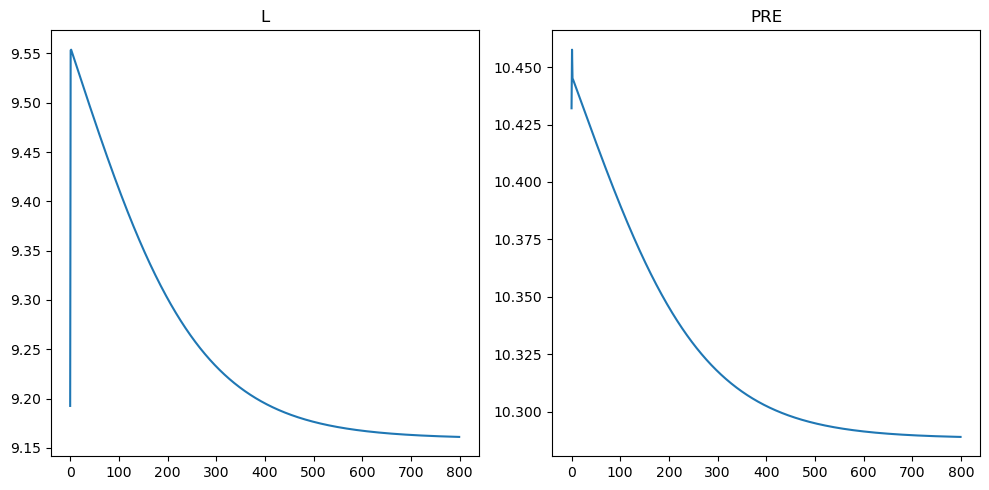

In [72]:

ls = [e['L'] for e in log]
pre = [e['PRE'] for e in log]
fig, ax = plt.subplots(1,2,figsize=(10,5))
ax[0].plot(ls)
ax[0].set_title('L')
ax[1].plot(pre)
ax[1].set_title('PRE')
fig.tight_layout()
plt.show()

In [73]:
plog = [e['grads']['policy'] for e in log]
print(pFun(plog[0]),pFun(plog[-1]))

[[8.66016040e-01 1.68427401e-02 5.13938963e-02 6.57473240e-02]
 [1.67265032e-01 3.63986365e-01 2.21817290e-04 4.68526786e-01]
 [6.21776736e-04 5.58080638e-01 2.96279249e-01 1.45018335e-01]
 [9.92027314e-01 2.26435921e-04 4.80871405e-03 2.93753599e-03]
 [5.17750472e-02 6.38027476e-01 7.56422871e-02 2.34555190e-01]
 [3.03330909e-03 3.51569833e-02 9.61751683e-01 5.80247464e-05]
 [9.29068624e-01 1.13477606e-02 5.95112325e-02 7.23825830e-05]
 [2.01214801e-02 2.80313335e-03 9.70463407e-01 6.61197973e-03]
 [9.59356779e-01 1.39261853e-02 2.40765883e-02 2.64044761e-03]] [[0.24998147 0.25000742 0.25000222 0.25000888]
 [0.25001046 0.25001085 0.24998961 0.24998908]
 [0.25000873 0.25000021 0.25000541 0.24998565]
 [0.24999358 0.25001041 0.2499932  0.2500028 ]
 [0.24999594 0.24999911 0.25000574 0.24999921]
 [0.25000845 0.24999002 0.25000087 0.25000066]
 [0.25000891 0.24999517 0.24998909 0.25000683]
 [0.24999328 0.25000276 0.24999193 0.25001203]
 [0.24999995 0.24999419 0.24999304 0.25001282]]


In [78]:
fR

DeviceArray([[ 0.00640515, -0.06531554, -0.06516833, -0.06679517],
             [ 0.50392666, -0.0552827 , -0.0445907 , -0.03956453],
             [-0.06016678,  0.44173192,  0.45551348, -0.03622561],
             [-0.02326782, -0.07218013, -0.07218363, -0.03918012],
             [ 0.00809647, -0.04828846, -0.06732814, -0.00190426],
             [-0.05894958, -0.04861618, -0.06437573,  0.5148165 ],
             [-0.04621272, -0.05818383, -0.05183423, -0.03023619],
             [-0.03006254, -0.06586693, -0.04885314, -0.02998614],
             [-0.05136008, -0.04673826, -0.0440729 , -0.00399013]],            dtype=float64)

In [79]:
newMDP = deepcopy(mdp)
newMDP.r = fR
new_policy = getExpertPolicy(newMDP,key,beta=10)


newMDP.r = fR
jnp.sum(newMDP.R,axis=1), jnp.sum(mdp.R,axis=1)

(DeviceArray([ -2.,  -1., 198.,  -1.,   0.,  -1.,  -2.,  -1.,  -2.], dtype=float64),
 DeviceArray([ -2.,  -1., 198.,  -1.,   0.,  -1.,  -2.,  -1.,  -2.], dtype=float64))

100%|██████████| 40/40 [00:01<00:00, 26.46it/s]


TypeError: FigureBase.colorbar() missing 1 required positional argument: 'mappable'

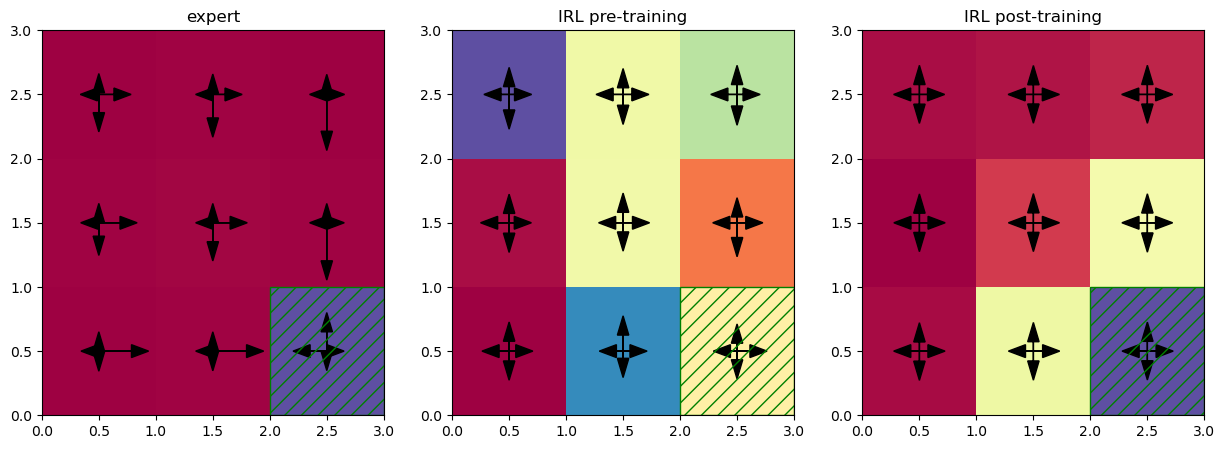

In [86]:
policies = jnp.array([e['params']['policy'] for e in log])
rewards = jnp.array([e['params']['reward'] for e in log])
oP = pFun(policies[0])
fP = pFun(policies[-1])
oR = rewards[0]
fR = rewards[-1]

from copy import deepcopy
key = jax.random.PRNGKey(0) 
newMDP = deepcopy(mdp)
newMDP.R = fR
new_policy = getExpertPolicy(newMDP,key,beta=10)


fig, ax = plt.subplots(1,3,figsize=(15,5))

gridplot(mdp,ax[0],scalar=jnp.sum(mdp.R,axis=1),stochastic_policy=expert,goals=[((2,0),1)])
ax[0].set_title('expert')
gridplot(mdp,ax[1],scalar=jnp.sum(oR,axis=1),stochastic_policy=oP,goals=[((2,0),1)])
ax[1].set_title('IRL pre-training')
gridplot(mdp,ax[2],scalar=jnp.sum(fR,axis=1),stochastic_policy=new_policy,goals=[((2,0),1)])
ax[2].set_title('IRL post-training')
fig.colorbar(ax=ax)
plt.show()